In [1]:
import qamuy.chemistry as qy
from qamuy.client import Client
import qamuy.plot

# You can fill in your e-mail address and password.
client = Client(email_address="", password="")


In [2]:
# setting = qy.QamuyChemistryInput()
input = qy.QamuyChemistryInput()


Molecule

In [3]:
distance = 1.5949 # Angstrom

molecule = input.target_molecule
molecule.geometry = qy.molecule_geometry(
    ["Li", "H"], [[0.0, 0.0, 0.00], [0.0, 0.0, distance]])
molecule.basis = "6-31g"
molecule.multiplicity = 1
molecule.sz_number = 0.0
molecule.num_excited_states = 2  # > 0 for calculating excited states
molecule.cas = qy.cas(2, 2)


In [4]:
# Solver
input.solver.type = "VQD"
# or "SSVQE", "MCVQE", "VQE"

# Ansatz
input.ansatz.type = "SYMMETRY_PRESERVING"
input.ansatz.depth = 4
# or "HARDWARE_EFFICIENT", "UCCSD", ...

# Optimizer
input.optimizer.type = "BFGS"
# or "SLSQP", "Adam", "NFT", "Powell", ...

# Device
input.quantum_device.type = "EXACT_SIMULATOR"
# or "SAMPLING_SIMULATOR"

# Cost Function
input.cost_function.type = "SIMPLE"
# add penalties
input.cost_function.s2_number_weight = 10.
input.cost_function.sz_number_weight = 10.
input.cost_function.particle_number_weight = 10.
# option for VQD
input.cost_function.overlap_weights = [10.] * molecule.num_excited_states

# Post-HF methods to make a comparison
input.post_hf_methods.append(qy.PostHFMethod(type="CASCI"))


Run jobs

In [5]:
job = client.submit(input)
results = client.wait_and_get_job_results([job])
output = results[0].output


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.0s finished


In [6]:
from pprint import pprint
# pprint(results[0].output)
# pprint(results[0].error)
# pprint(results[0].status)

In [7]:
pprint(results[0].error)

None


Get results

### Ouput Structure
Qamuy output object has the following structure.

QamuyChemistryOutput:

- input
- molecule_result
    - hamiltonian_generation
    - hf_result
    - post_hf_results
        - post_hf_log
        - evaluated_properties
    - quantum_device
        - vqe_log
            - cost_hist
            - nfev
            - nit
            - opt_params
            - quantum_resources
                - circuit
                - estimated_execution_time
                - sampling
        - evaluated_properties


In [8]:
## get results
q_result = output.molecule_result.quantum_device_result
c_result = output.molecule_result.post_hf_results[0]
vqe_log = q_result.vqe_log

## chemical properties
for i in range(1 + molecule.num_excited_states):  # ground state and all excited states
    print(f'S{i} energy: {qy.get_evaluated_property_for_state(q_result, "energy", state=i).value}')



S0 energy: -7.979410371934568
S1 energy: -7.8299520975918755
S2 energy: -7.305933835615816


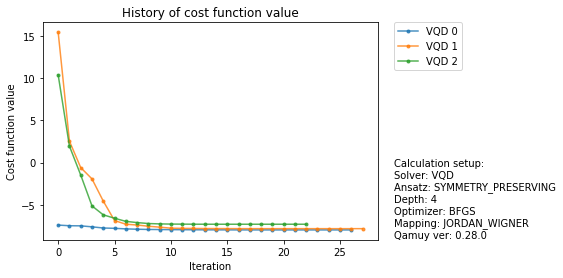

In [9]:
## Plot the cost function history (cost function = energy + penalty terms)
fig, ax = qamuy.plot.plot_cost_history(output)


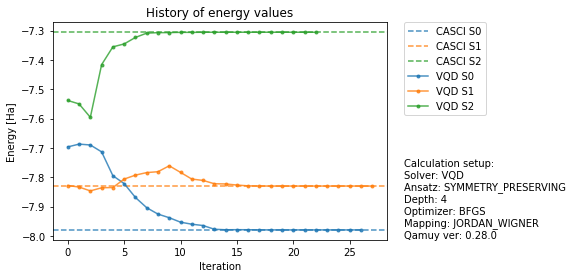

In [10]:
## plot energy history
# fig, ax = qamuy.plot.plot_energy_history(output, state_label_map={0: "S0"}) # for groundstate
state_label_map = {}
for i in range(1 + molecule.num_excited_states): # ground state and all excited states
    state_label_map[i] = f"S{i}"
# state_label_map
fig, ax = qamuy.plot.plot_energy_history(
    output, state_label_map=state_label_map)


In [11]:
## get evaluated results
pprint(q_result.evaluated_properties)


[{'energy': {'values': [{'value': -7.979410371934568, 'state': 0, 'sample_std': 0.0}, {'state': 1, 'value': -7.8299520975918755, 'sample_std': 0.0}, {'state': 2, 'value': -7.305933835615816, 'sample_std': 0.0}], 'metadata': {'elapsed_time': 0.002435219999938454, 'success': True}}}, {'num_electrons': {'values': [{'value': 2.0000000000000027, 'state': 0}, {'state': 1, 'value': 2.0000000000000004}, {'state': 2, 'value': 2.0}], 'metadata': {'elapsed_time': 0.0017542140000159634, 'success': True}}}, {'multiplicity': {'values': [{'value': 1.0000000000000082, 'state': 0}, {'state': 1, 'value': 1.0000000000000002}, {'state': 2, 'value': 1.0000000000000053}], 'metadata': {'elapsed_time': 0.002146118000041497, 'success': True}}}, {'sz_number': {'values': [{'value': -6.661338147750939e-16, 'state': 0}, {'state': 1, 'value': 0.0}, {'state': 2, 'value': 6.938893903907228e-16}], 'metadata': {'elapsed_time': 0.0017909150000150476, 'success': True}}}]
